<a href="https://colab.research.google.com/github/yakkunn7422/public_colab/blob/main/ai_contest_misc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -fr /content/sample_data/new_train_images
!rm -fr /content/sample_data/test_images.zip
!rm -fr /content/sample_data/train_images.zip
!rm -fr /content/sample_data/train_master.tsv
!rm -fr /content/sample_data/sample_submit.tsv
!rm -fr /content/sample_data/resnet18-5c106cde.pth
!rm -fr /content/sample_data/label_master.tsv


In [ ]:
import os
import zipfile

#ZIPファイルの解凍
sample_dir = "/content/sample_data"
os.chdir(sample_dir)
with zipfile.ZipFile('/content/drive/MyDrive/2024_AIContest2/Thema2/met_data_2018_01.zip') as myzip:
     myzip.extractall()

<class 'numpy.ndarray'>
(168, 128)
最大値:  296.1921
最小値:  0.0
平均値:  236.1134
最大値:  296.1921
最小値:  245.02959
平均値:  279.20624


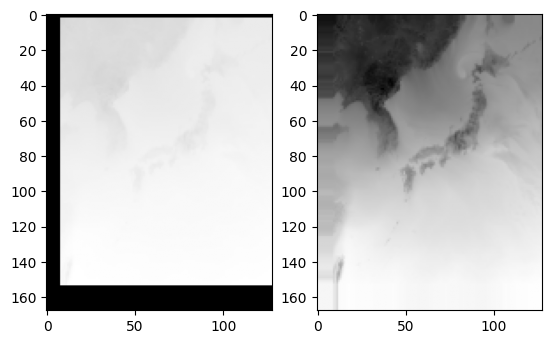

In [ ]:
# HGT: PMMSL:海面気温 RH:湿度 TMP:気温 UGRD:東西風 VGRD:南北風 VVEL:鉛直流

# ライブラリのインポート
import numpy as np
import gzip
import shutil
import matplotlib.pyplot as plt
# 気象データを読み込む関数; Read_gz_Binary を実装する
def Read_gz_Binary(file_path):
    file_tmp = file_path + "_tmp"
    with gzip.open(file_path, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # バイナリファイルをNumPy配列として読み込む
    met_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)

    # 配列の次元に変更を加える
    met_data = met_data.reshape( [168,128] )

    return met_data

# 気象データのファイルパスを指定する
file_path = '/content/sample_data/test/met/2018/01/02/TMP.1p5m.3.2018010218.gz'

# 気象データを読み込む
met_data = Read_gz_Binary(file_path)

# 読み込んだ気象データに関する基本情報を出力する
print(type(met_data))
print(met_data.shape)

# 最大値の出力
print('最大値: ', np.max(met_data))
# 最小値の出力
print('最小値: ', np.min(met_data))
# 平均値の出力
print('平均値: ', np.mean(met_data))

#print(met_data)

plt.subplot(1, 2, 1)
plt.imshow(met_data, 'gray')

# fill_lack_data()関数を実装する
def fill_lack_data(data):
    ## 1. 北側、南側の未計測部分を補間する(上下)
    # 北側の未計測部分を補間する
    data[0:2] = data[2]
    # 南側の未計測部分を補間する
    data[154:] = data[153]
    ## 2. 西側の未計測部分を補間する(左右)
    # 西側の未計測部分を補間する
    data[:, :8] = data[:,8].reshape(-1, 1)

    return data

# fill_lack_data()関数をmet_dataに対して実行する
filled_data = fill_lack_data(met_data)

# 最大値の出力
print('最大値: ', np.max(met_data))
# 最小値の出力
print('最小値: ', np.min(met_data))
# 平均値の出力
print('平均値: ', np.mean(met_data))

plt.subplot(1, 2, 2)
plt.imshow(filled_data, 'gray')

plt.show()



In [ ]:
#指定したディレクトリ配下の画像を一覧表示させるコード
import os
from PIL import Image
import matplotlib.pyplot as plt
def display_images_from_directory(directory, images_per_row=5, max_display_count=20):
    # ファイルリストを取得
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # 画像ファイルだけをフィルター
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
    # プロット設定
    num_images = min(len(image_files), max_display_count)
    plt.figure(figsize=(15, num_images // images_per_row * 3))

    for i, image_name in enumerate(image_files):
        if i >= max_display_count:
            break

        image_path = os.path.join(directory, image_name)

        with Image.open(image_path) as img:
            # 画像サイズを取得
            image_size = img.size
            image_size_kb = os.path.getsize(image_path) // 1024

        # プロット位置を設定
        ax = plt.subplot(num_images // images_per_row + 1, images_per_row, i + 1)

        # 画像を表示
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')

        # ファイル名とサイズを表示
        plt.title(f"{image_name}\n{image_size[0]}x{image_size[1]} px\n{image_size_kb} KB", fontsize=8)
    # レイアウト調整
    plt.tight_layout()
    plt.show()

# 使用例: ディレクトリパスを指定
directory_path = '/content/sample_data/test_images'

# 使用例: １列に3つずつ。最大20画像表示
display_images_from_directory(directory_path, images_per_row=3, max_display_count=20)

In [ ]:
#■trainデータを 学習(train)と評価(val)に分割し、Resnet18の使用前提条件にあわせたディレクトリ構成にする為のコード
#　使用条件：以下ファイルが必要
#　　train.zip　…　学習用の画像がディレクトリ内にまとめて格納されている
#　　　→配置場所：/content/drive/MyDrive/2024_AIContest2_thema1/Thema1/train_images.zip
#　　train_master.tsv　… 画像毎のラベルがまとめられたファイル
#　　　→配置場所：/content/drive/MyDrive/2024_AIContest2_thema1/Thema1/train_master.tsv
import os
import pandas as pd
import zipfile
import shutil
import numpy as np

# トレインとバリデーション用のディレクトリおよびその中のラベルごとのサブディレクトリを作成する
def create_directories(base_dir, labels):

    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    for dir_path in [train_dir, val_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    for label in labels:
        os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)
        os.makedirs(os.path.join(val_dir, str(label)), exist_ok=True)

    return train_dir, val_dir

# ZIPファイルを解凍する
def extract_zip(zip_file_path, extract_to):

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# TSVファイルを読み込み、1行目を削除してデータフレームを準備する
def load_and_prepare_data(tsv_file_path):

    df = pd.read_csv(tsv_file_path, sep='\t', names=['filename', 'label_id'])
    df = df.iloc[1:].reset_index(drop=True)

    return df

# 画像ファイルをディレクトリに分配する
def distribute_images(df, image_dir, train_dir, val_dir, train_ratio=0.8):

    for label in df['label_id'].unique():
        label_images = df[df['label_id'] == label]['filename'].tolist()
        # シャッフルして分割

        np.random.shuffle(label_images)
        train_size = int(len(label_images) * train_ratio)
        train_images = label_images[:train_size]
        val_images = label_images[train_size:]

        for image_name in train_images:
            src_path = os.path.join(image_dir, image_name)
            dst_path = os.path.join(train_dir, str(label), image_name)
            shutil.copy(src_path, dst_path)

        for image_name in val_images:
            src_path = os.path.join(image_dir, image_name)
            dst_path = os.path.join(val_dir, str(label), image_name)
            shutil.copy(src_path, dst_path)

# ディレクトリ内のアイテムを探索し数を表示する
def count_files_recursive(directory):
    total_files = 0

    for root, dirs, files in os.walk(directory):
        files_count = len(files)
        subdir_relative = os.path.relpath(root, directory)
        print(f"Directory '{subdir_relative}' contains {files_count} files.")

        total_files += files_count

    print(f"Total files in '{directory}': {total_files}")

# メイン処理を実行する関数
def main(zip_file_path, tsv_file_path, output_dir, train_ratio=0.8):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = load_and_prepare_data(tsv_file_path)

    extract_zip(zip_file_path, output_dir)

    labels = df['label_id'].unique()

    train_dir, val_dir = create_directories(output_dir, labels)
    image_dir = os.path.join(output_dir, 'train_images')

    distribute_images(df, image_dir, train_dir, val_dir, train_ratio)

# 実行
zip_file_path = '/content/drive/MyDrive/2024_AIContest2_thema1/Thema1/train_images.zip'
tsv_file_path = '/content/drive/MyDrive/2024_AIContest2_thema1/Thema1/train_master.tsv'
output_dir = '/content/sample_data/new_train_images'

main(zip_file_path, tsv_file_path, output_dir, train_ratio=0.8)

count_files_recursive(output_dir)
